In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# replicate figure 7 from carlsten 

setup: calculate the proportion of transaction fees earned by an adversary playing the pure selfish strategy given block times modelled as an exponential distribution.

In [264]:
state = [0,0] # (attacker, honest)
alpha = 0.3

honestBlcs = 0
attackBlcs = 0

for _ in tqdm(range(int(1e5))):
    attBlock  = np.random.binomial(1, alpha)

    if state == [0,0]:
        if attBlock:
            state = [1,0]
        else:
            honestBlcs += 1
        continue
    
    if state == [1,0]:
        if attBlock:
            state = [2,0]
        else:
            nextAttBlock  = np.random.binomial(1, alpha)
            if nextAttBlock:
                attackBlcs += 2
            else:
                honestBlcs += 2
            state = [0,0]
        continue
        
    if attBlock:
        state[0] += 1
    else:
        state[1] += 1
    
    diff = state[0] - state[1]
    if diff == 1:
        attackBlcs += state[0]
        state = [0,0]

totalBlcs = honestBlcs + attackBlcs
(honestBlcs/totalBlcs, attackBlcs/totalBlcs), honestBlcs, totalBlcs

100%|██████████| 100000/100000 [00:00<00:00, 258374.64it/s]


((0.7287714014834644, 0.27122859851653564), 65338, 89655)

In [273]:
def simNoGamma(alpha, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    for _ in range(n):
        attBlock  = np.random.binomial(1, alpha)

        if state == [0,0]:
            if attBlock:
                state = [1,0]
            else:
                honestBlcs += 1
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
            else:
                nextAttBlock  = np.random.binomial(1, alpha)
                if nextAttBlock:
                    attackBlcs += 2
                else:
                    honestBlcs += 2
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            state = [0,0]

    totalBlcs = honestBlcs + attackBlcs
    return attackBlcs/totalBlcs

In [254]:
def EyalSirer(a, g):
    num = a * ((1-a)**2) * (4*a + g*(1-2*a)) - a**3
    den = 1 - a * (1 + (2-a) * a)
    return num / den

In [384]:
EyalSirer(0.3, 0)

0.27312614259597795

In [265]:
alphas = np.arange(0.01, 0.5, 0.001)
g0s    = [EyalSirer(a, 0) for a in alphas]

In [ ]:
simAlphas = np.arange(0.025, 0.5, 0.025)
simg0s = []
for i, a in tqdm(enumerate(simAlphas)):
    temp = []
    for j in range(10):
        temp.append(simNoGamma(a))
    simg0s.append(np.mean(temp))

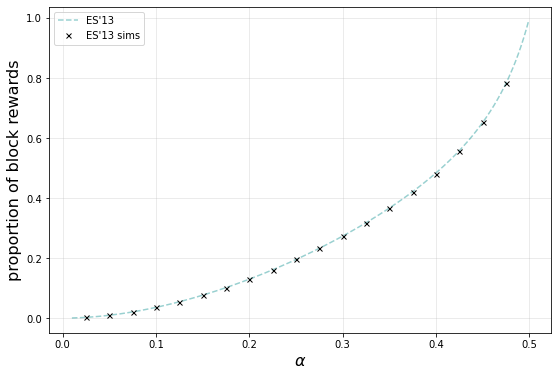

In [301]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(alphas, g0s, label='ES\'13', linestyle='--', color='darkcyan', alpha=0.4)
ax.plot(simAlphas, simg0s, linestyle='none', color='black', marker='x', fillstyle='none',
        markersize=5, label='ES\'13 sims')

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'proportion of block rewards', size=16)
# ax.set_xlim(0.25, 0.4)
# ax.set_ylim(0.2,0.45)
ax.legend()
plt.show()

# adding txn fees

In [482]:
def Carlsten2(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [519]:
def Carlsten(a, g):
    num = 5*(a**2) - 12*(a**3) + 9*(a**4) - 2*(a**5) + g * (a - 4*(a**2) + 6*(a**3) - 5*(a**4) + 2*(a**5))
    den = 2*(a**3) - 4*(a**2) + 1
    return num / den

In [523]:
Carlsten(0.3, 0), Carlsten2(0.3, 100)

(0.27959654178674354, 0.290958904109589)

In [514]:
## SYMBOLIC INTERLUDE
a, b, g = sp.symbols('alpha beta gamma')

num1 = 1 + b * (1-a)**2 * (1-g)
den1 = sp.exp(b) - 1

expr1 = num1 / den1
expr2 = 5*a + (1-a)**2 * g + 2*a**2/(1-2*a) - 2*a**2
expr3 = expr1 + expr2

num2 = a * (1-2*a) * (1-sp.exp(-b))
den2 = 1 - 2 * sp.exp(-b) * a - 3 * (1-sp.exp(-b)) * a**2
expr4 = num2 / den2

full = expr3 * expr4
full

alpha*(1 - 2*alpha)*(1 - exp(-beta))*(-2*alpha**2 + 2*alpha**2/(1 - 2*alpha) + 5*alpha + gamma*(1 - alpha)**2 + (beta*(1 - alpha)**2*(1 - gamma) + 1)/(exp(beta) - 1))/(-alpha**2*(3 - 3*exp(-beta)) - 2*alpha*exp(-beta) + 1)

In [518]:
selfishC = sp.limit(full, b, sp.oo)
selfishC

(2*alpha**4*gamma - 4*alpha**4 - 5*alpha**3*gamma + 10*alpha**3 + 4*alpha**2*gamma - 5*alpha**2 - alpha*gamma)/(3*alpha**2 - 1)

In [526]:
selfishCNum = sp.lambdify((a, g), selfishC)
selfishCNum(0.3, 0)

0.290958904109589

In [527]:
alphas  = np.arange(0.01, 0.5, 0.001)
g0sC    = [Carlsten(a, 0) for a in alphas]
g0sC2   = [selfishCNum(a, 0) for a in alphas]

In [459]:
state = [0,0] # (attacker, honest)
alpha = 0.3

honestBlcs = 0
attackBlcs = 0
honestRews = 0
attackRews = 0
curTime    = 0
lastState0 = 0
lastAttBlc = 0

for _ in tqdm(range(int(1e5))):
    attBlock = np.random.binomial(1, alpha)
    execRews = np.random.exponential(100)
    curTime += execRews

    if state == [0,0]:
        if attBlock:
            state = [1,0]
            lastAttBlc = curTime
        else:
            honestBlcs += 1
            honestRews += execRews
            lastState0  = curTime
        continue
    
    if state == [1,0]:
        if attBlock:
            state = [2,0]
            lastAttBlc = curTime
        else:
            nextAttBlock  = np.random.binomial(1, alpha)
            nextExecRews  = np.random.exponential()
            curTime      += nextExecRews
            if nextAttBlock:
                attackBlcs += 2
                attackRews += (curTime - lastState0)
                lastState0  = curTime
            else:
                honestBlcs += 2
                honestRews += (curTime - lastState0)
                lastState0  = curTime
            state = [0,0]
        continue
        
    if attBlock:
        state[0] += 1
        lastAttBlc = curTime
    else:
        state[1] += 1
    
    diff = state[0] - state[1]
    if diff == 1:
        attackBlcs += state[0]
        attackRews += (lastAttBlc - lastState0)
        
        # 0'' state
        remRews = (curTime - lastAttBlc)
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential(100)
        if attBlock:
            attackRews += (remRews + execRews)
        else:
            honestRews += (remRews + execRews)
        
        lastState0  = curTime
        lastAttBlc  = curTime
        state = [0,0]

totalRews = honestRews + attackRews
totakBlcs = honestBlcs + attackBlcs
(honestRews/totalRews, attackRews/totalRews), (honestBlcs/totakBlcs, attackBlcs/totakBlcs)

100%|██████████| 100000/100000 [00:00<00:00, 134653.83it/s]


((0.7172528553880362, 0.2827471446119637),
 (0.7313565538242681, 0.2686434461757318))

In [479]:
def simNoGammaC(alpha, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                state = [1,0]
                lastAttBlc = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                nextAttBlock  = np.random.binomial(1, alpha)
                nextExecRews  = np.random.exponential()
                curTime      += nextExecRews
                if nextAttBlock:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0)
                    lastState0  = curTime
                    lastAttBlc  = curTime
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0)
                    lastState0  = curTime
                    lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackRews += (remRews + execRews)
            else:
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [480]:
simAlphas = np.arange(0.025, 0.5, 0.025)
simg0sC = []
for i, a in tqdm(enumerate(simAlphas)):
    temp = []
    for j in range(10):
        temp.append(simNoGammaC(a))
    simg0sC.append(np.mean(temp))

19it [02:06,  6.93s/it]

KeyboardInterrupt: 

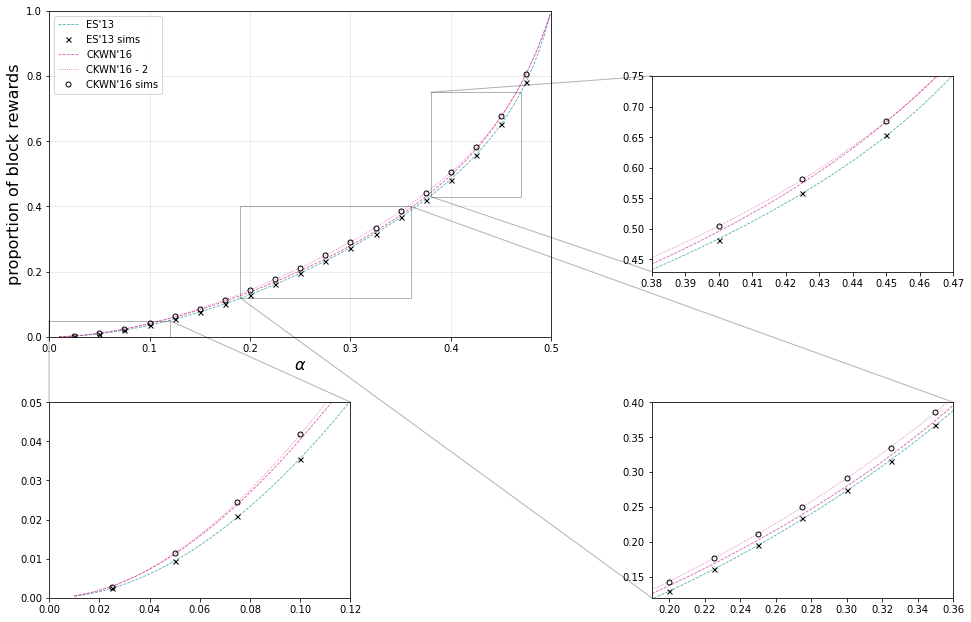

In [530]:
f, ax = plt.subplots(figsize=(9,6))

axins0 = ax.inset_axes([0., -0.8, 0.6, 0.6], xlim=(0., 0.12), ylim=(0., .05))
axins1 = ax.inset_axes([1.2, 0.2, 0.6, 0.6], xlim=(0.38, 0.47), ylim=(0.43, 0.75))
axins2 = ax.inset_axes([1.2, -0.8, 0.6, 0.6], xlim=(0.19, 0.36), ylim=(0.12, 0.4))
ax.indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)

for a in [ax, axins0, axins1, axins2]:
    a.plot(alphas, g0s, label='ES\'13', linestyle='--', color='darkcyan', alpha=0.7, linewidth=0.8)
    a.plot(simAlphas, simg0s, linestyle='none', color='black', marker='x', fillstyle='none',
            markersize=5, label='ES\'13 sims')

    a.plot(alphas, g0sC, label='CKWN\'16', linestyle='--', color='mediumvioletred', alpha=0.7, linewidth=0.8)
    a.plot(alphas, g0sC2, label='CKWN\'16 - 2', linestyle='dotted', color='mediumvioletred', alpha=0.7, linewidth=0.8)
    a.plot(simAlphas, simg0sC, linestyle='none', color='black', marker='o', fillstyle='none',
            markersize=5, label='CKWN\'16 sims')

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'proportion of block rewards', size=16)
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)
ax.legend()
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')

plt.show()

In [ ]:
state = 0
alpha = 0.3

honestRews = 0
attackRews = 0
remainRews = 0
honestBlcs = 0
attackBlcs = 0

for _ in tqdm(range(int(1e5))):
    blockTime = np.random.exponential(1/100000)
    attBlock  = np.random.binomial(1, alpha)

    if state == 0 and attBlock:
        state       = 1
        remainRews += blockTime  # unclaimed exec rewards on private branch
    elif state == 0 and not attBlock:
        honestRews += blockTime
        honestBlcs += 1

    if state == 1 and attBlock:
        state       = 2
        attackRews += (remainRews + blockTime)  # attacker locks in both blocks worth of exec rewards
        attackBlcs += 2
        remainRews  = 0
    elif state == 1 and not attBlock:
        nextBlockTime = np.random.exponential()
        nextAttBlock  = np.random.binomial(1, alpha)
        # attacker wins all three time period's worth of exec rewards
        if nextAttBlock:
            attackRews += (remainRews + blockTime + nextBlockTime)
            attackBlcs += 2
        #   honest wins all three time period's worth of exec rewards
        else:
            honestRews += (remainRews + blockTime + nextBlockTime)
            honestBlcs += 2
        remainRews = 0

    if state == 2 and attBlock:
        state        = 3
        attackRews  += (remainRews + blockTime)
        remainRews   = 0
        attackBlcs  += 1
    elif state == 2 and not attBlock:
        nextBlockTime = np.random.exponential()
        nextAttBlock  = np.random.binomial(1, alpha)
        # attacker wins all outstanding exec rewards
        if nextAttBlock:
            attackRews += (remainRews + blockTime + nextBlockTime)
            attackBlcs  += 1
        #   honest wins all outstanding exec rewards
        else:
            honestRews  += (remainRews + blockTime + nextBlockTime)
            honestBlcs  += 1
        remainRews = 0

    if state > 2 and attBlock:
        state        += 1
        attackRews   += (remainRews + blockTime)
        remainRews    = 0
        attackBlcs   += 1
    elif state > 2 and not attBlock:
        state      -= 1
        remainRews += blockTime

totalRews = honestRews + attackRews
totalBlcs = honestBlcs + attackBlcs
(honestRews/totalRews, attackRews/totalRews), (honestBlcs/totalBlcs, attackBlcs/totalBlcs), honestBlcs, totalBlcs